# Preliminary Models | data: top 20m of ocean

**Linear Regression**

**Gradient Boosting Regressor**

**XGBRegressor**

**Decision Tree Regressor**

**Random Forest Regressor**

Josie Donnelly

*Last updated 12.16.22*

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from statistics import mode
from datetime import datetime
from time import time

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import Normalize, LogNorm

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor


## Preprocessing

In [2]:
# load satellite data
sat_data_path = r'/Users/josiedonnelly/Desktop/DS Capstone ENGIE4800/data/'
sat_data_file = 'satData.csv'
sat_df = pd.read_csv(sat_data_path + sat_data_file)

# add date column as datetime
sat_df.rename({'date': 'date_str'}, axis=1, inplace=True)
sat_df.insert(loc=list(sat_df.columns).index('date_str'), column='date', value=[datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in sat_df['date_str']])

# drop long term average columns
for c in sat_df.columns:
    if c.startswith('LT'):
        sat_df.drop(columns=c, inplace=True)
        
# to start, consider only instances with no missing values
sat_df = sat_df.dropna(axis=0).reset_index(drop=True)

print(f'shape: {sat_df.shape}\n')

print(f'missing values:\n---------------\n{sat_df.isna().sum()}\n')

print(f'number of unique floats: {len(np.unique(sat_df["float"]))}\n')

sat_df


shape: (52038, 10)

missing values:
---------------
float          0
cycleNumber    0
date           0
date_str       0
latitude       0
longitude      0
elevation      0
MO_SAT_SST     0
MO_SAT_CHL     0
MO_SAT_BBP     0
dtype: int64

number of unique floats: 553



,float,cycleNumber,date,date_str,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,MO_SAT_BBP
0,1902303,1,2021-05-06 02:03:16,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340
1,1902303,2,2021-05-06 19:32:57,2021-05-06 19:32:57,49.096000,-14.617000,-4612.0,12.466026,0.782180,0.003081
2,1902303,3,2021-05-07 20:05:38,2021-05-07 20:05:38,48.914000,-14.606000,-4700.0,12.424099,0.458020,0.003185
3,1902303,4,2021-05-08 22:42:52,2021-05-08 22:42:52,48.794000,-14.689000,-4753.0,12.374519,0.378064,0.001767
4,1902303,5,2021-05-09 20:29:00,2021-05-09 20:29:00,48.719000,-14.795000,-4765.0,12.204494,0.411479,0.001677
...,...,...,...,...,...,...,...,...,...,...
52033,7901001,11,2022-03-23 11:26:00,2022-03-23 11:26:00,17.130858,-24.169882,-3323.5,21.762587,0.390988,0.001562
52034,7901001,12,2022-03-25 11:31:00,2022-03-25 11:31:00,16.967572,-23.922267,-3457.5,21.850749,0.208484,0.001078
52035,7901001,13,2022-03-27 11:57:00,2022-03-27 11:57:00,16.803187,-23.777600,-3359.5,21.975307,0.162081,0.001127
52036,7901001,14,2022-03-29 11:35:00,2022-03-29 11:35:00,16.647572,-23.731805,-3358.5,22.266691,0.179276,0.001053


In [3]:
# load float data with location
float_loc_data_path = r'/Users/josiedonnelly/Desktop/DS Capstone ENGIE4800/data/'
float_loc_data_file = 'floatLocData.csv'

try:
    # read saved joined dataframe
    date_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    float_loc_df = pd.read_csv(float_loc_data_path + float_loc_data_file, parse_dates=['date'], date_parser=date_parser)     #.drop(columns='date')
#     float_loc_df.insert(loc=list(float_loc_df.columns).index('date_str'), column='date', value=[datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in float_loc_df['date_str']])
    
except FileNotFoundError:   
    print('Joining profile data on global float data...')
    start_time = time()
    
    # load float profile data
    float_data_path = r'/Users/josiedonnelly/Desktop/DS Capstone ENGIE4800/data/'
    float_data_file = 'profileData.csv'
    float_df = pd.read_csv(float_data_path + float_data_file)

    # add date column as datetime
    float_df.rename({'date': 'date_str'}, axis=1, inplace=True)
    float_df.insert(loc=list(float_df.columns).index('date_str'), column='date', value=[datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in float_df['date_str']])

    # join float profile data on location
    float_loc_df = pd.DataFrame(columns=list(float_df.columns)[:1] + ['latitude', 'longitude'] + list(float_df.columns)[1:])
    for f in np.unique(float_df['float']):
        tmp_float_df = float_df[float_df['float'] == f]
        tmp_loc_df = loc_df[loc_df['float'] == f]
        tmp_df = tmp_loc_df.join(other=tmp_float_df.set_index('date'), on='date', how='inner', rsuffix='_copy')
        for c in tmp_df.columns:
            if c.endswith('_copy'):
                tmp_df.drop(columns=c, inplace=True)
        try:
            float_loc_df = pd.concat([float_loc_df, tmp_df])
        except:
            print(f'error with feature {f}')

    float_loc_df = float_loc_df.reset_index(drop=True)
    
    # confirm that the satellite and float data files contain information for exactly the same floats
    print(f"satellite and float data file contain information for exactly the same floats: {np.array_equal(np.unique(float_df['float']), np.unique(sat_df['float']))}")

    # save joined table locally
    print(f'Saving joined table to {float_loc_data_path + float_loc_data_file}...')
    float_loc_df.to_csv(float_loc_data_path + float_loc_data_file, index=False, date_format='%Y-%m-%d %H:%M:%S')
    print(f'Done -- time taken = {time() - start_time:.4f}s')

# either way, display dataframe information and data

# drop irrelevant columns
for c in float_loc_df.columns:
    if c not in ['float', 'latitude', 'longitude', 'date', 'date_str', 'PRES', 'BBP700', 'CHLA']:
        float_loc_df.drop(columns=c, inplace=True)
        
# to start, consider only instances with no missing values
float_loc_df = float_loc_df.dropna(axis=0).reset_index(drop=True)

print(f'shape: {float_loc_df.shape}\n')

print(f'missing values:\n---------------\n{float_loc_df.isna().sum()}\n')

print(f'number of unique floats: {len(np.unique(float_loc_df["float"]))}\n')

float_loc_df


shape: (33057018, 8)

missing values:
---------------
float        0
latitude     0
longitude    0
date         0
date_str     0
PRES         0
BBP700       0
CHLA         0
dtype: int64

number of unique floats: 565



,float,latitude,longitude,date,date_str,PRES,BBP700,CHLA
0,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,3,0.001788,6.958747e-01
1,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,4,0.001788,6.958747e-01
2,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,6,0.001788,6.964993e-01
3,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,8,0.001789,7.164887e-01
4,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,10,0.001790,7.155517e-01
...,...,...,...,...,...,...,...,...
33057013,7901001,17.330,-23.271,2022-05-23 11:34:00,2022-05-23 11:34:00,968,0.000216,-3.686869e-05
33057014,7901001,17.330,-23.271,2022-05-23 11:34:00,2022-05-23 11:34:00,975,0.000216,-1.843434e-05
33057015,7901001,17.330,-23.271,2022-05-23 11:34:00,2022-05-23 11:34:00,977,0.000216,2.543358e-18
33057016,7901001,17.330,-23.271,2022-05-23 11:34:00,2022-05-23 11:34:00,982,0.000216,2.543358e-18


In [4]:
# join CHLA data onto satellite information based on lat, long, and date
depth_thresh = 20
float_loc_df10 = float_loc_df[float_loc_df['PRES'] < depth_thresh]
chla_vals = []
rows_to_drop = []
for i in range(sat_df.shape[0]):
    row = sat_df.loc[i]
    tmp_df = float_loc_df10[(float_loc_df10['date'] == row['date']) & (float_loc_df10['float'] == row['float'])]
    if tmp_df.shape[0] > 0:
        chla_vals.append(np.mean(tmp_df['CHLA']))
    else:
        rows_to_drop.append(i)
        
data_df = sat_df.drop(labels=rows_to_drop, axis='index').reset_index(drop=True)
data_df['target_CHLA'] = chla_vals

print(data_df.shape)
data_df


(45741, 11)


,float,cycleNumber,date,date_str,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,MO_SAT_BBP,target_CHLA
0,1902303,1,2021-05-06 02:03:16,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340,0.705323
1,1902303,2,2021-05-06 19:32:57,2021-05-06 19:32:57,49.096000,-14.617000,-4612.0,12.466026,0.782180,0.003081,0.675526
2,1902303,3,2021-05-07 20:05:38,2021-05-07 20:05:38,48.914000,-14.606000,-4700.0,12.424099,0.458020,0.003185,1.066021
3,1902303,4,2021-05-08 22:42:52,2021-05-08 22:42:52,48.794000,-14.689000,-4753.0,12.374519,0.378064,0.001767,1.414944
4,1902303,5,2021-05-09 20:29:00,2021-05-09 20:29:00,48.719000,-14.795000,-4765.0,12.204494,0.411479,0.001677,1.024918
...,...,...,...,...,...,...,...,...,...,...,...
45736,7901001,11,2022-03-23 11:26:00,2022-03-23 11:26:00,17.130858,-24.169882,-3323.5,21.762587,0.390988,0.001562,0.186150
45737,7901001,12,2022-03-25 11:31:00,2022-03-25 11:31:00,16.967572,-23.922267,-3457.5,21.850749,0.208484,0.001078,0.065700
45738,7901001,13,2022-03-27 11:57:00,2022-03-27 11:57:00,16.803187,-23.777600,-3359.5,21.975307,0.162081,0.001127,0.025641
45739,7901001,14,2022-03-29 11:35:00,2022-03-29 11:35:00,16.647572,-23.731805,-3358.5,22.266691,0.179276,0.001053,0.065700


In [5]:
data_df.insert(loc=list(data_df.columns).index('date'), column='day_of_year_rad', value=[(int(d.strftime('%j'))*np.pi)/182.625 for d in data_df['date']])
# data_df.drop(columns=['float', 'cycleNumber', 'date', 'date_str', 'elevation', 'MO_SAT_CHL'], inplace=True)
data_df.drop(columns=['float', 'cycleNumber', 'date', 'date_str', 'elevation'], inplace=True)     # include monthly chlorophyll; we are open to all potentially predictive satellite features

data_df


,day_of_year_rad,latitude,longitude,MO_SAT_SST,MO_SAT_CHL,MO_SAT_BBP,target_CHLA
0,2.167505,49.236000,-14.742000,12.451869,0.435093,0.003340,0.705323
1,2.167505,49.096000,-14.617000,12.466026,0.782180,0.003081,0.675526
2,2.184708,48.914000,-14.606000,12.424099,0.458020,0.003185,1.066021
3,2.201910,48.794000,-14.689000,12.374519,0.378064,0.001767,1.414944
4,2.219113,48.719000,-14.795000,12.204494,0.411479,0.001677,1.024918
...,...,...,...,...,...,...,...
45736,1.410599,17.130858,-24.169882,21.762587,0.390988,0.001562,0.186150
45737,1.445004,16.967572,-23.922267,21.850749,0.208484,0.001078,0.065700
45738,1.479408,16.803187,-23.777600,21.975307,0.162081,0.001127,0.025641
45739,1.513813,16.647572,-23.731805,22.266691,0.179276,0.001053,0.065700


In [6]:
# split training, validation, and testing data
# note: more sophisticated train-test split is needed to ensure a balanced dataset in terms of location and time (season)
X = data_df.drop(columns='target_CHLA')
y = data_df['target_CHLA']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Num train samples: {X_train.shape[0]}')
print(f'Num test samples: {X_test.shape[0]}')


Num train samples: 36592
Num test samples: 9149


In [7]:
# apply standard scaler
ss = StandardScaler()
X_train[X_train.columns] = ss.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = ss.transform(X_test[X_test.columns])


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [8]:
# summarize data input into following models
print(f'Depth threshold: {depth_thresh}')
print(f'Input features: {list(data_df.columns)[:-1]}')
print(f'Output: {list(data_df.columns)[-1]}')

# initialize dataframe to store results
results_df = pd.DataFrame(columns=['model', 'train_mse', 'train_r2', 'test_mse', 'test_r2'])


Depth threshold: 20
Input features: ['day_of_year_rad', 'latitude', 'longitude', 'MO_SAT_SST', 'MO_SAT_CHL', 'MO_SAT_BBP']
Output: target_CHLA


## Define functions

In [9]:
# function to cross validate and display scores
def get_model_scores(model, X, y, metrics=['neg_mean_squared_error', 'r2'], n_cv_folds=5):
    scores = cross_validate(model, X, y, cv=n_cv_folds,
                           scoring=metrics,
                           return_estimator=True,
                           return_train_score=True)
    
    vals = []
    for group in ['train', 'test']:
        for metric in metrics:
            if metric == 'neg_mean_squared_error':
                val = np.mean(-scores[f'{group}_{metric}'])
                metric = 'MSE'
            else:
                val = np.mean(scores[f'{group}_{metric}'])
            
            if group == 'test':
                print(f"{f'Average validation {metric}:':<25} {val:.4f}")
            else:
                print(f"{f'Average {group} {metric}:':<25} {val:.4f}")
                
            vals.append(val)
            
        print()
        
    
    return vals


In [10]:
# function to fit model on training and testing data
# returns predictions on train and test data
def fit_predict(model, X_train, X_test, y_test):
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    print(f"{'Final test MSE:':<25} {mean_squared_error(y_test, test_preds):.4f}")
    print(f"{'Final test r2:':<25} {r2_score(y_test, test_preds):.4f}")
    
    return train_preds, test_preds
    

In [11]:
# display the results of the regression as scatter plots: predicted value vs. target
def plot(y_train, train_preds, y_test, test_preds, subplot, title):  
    plt.subplot(2,3,subplot)

    plt.scatter(y_train, train_preds, label=f'train (r2 = {r2_score(y_train, train_preds):.2f})', alpha=0.7)
    plt.scatter(y_test, test_preds, label=f'test (r2 = {r2_score(y_test, test_preds):.2f})', alpha=0.7)
    plt.title(title)
    plt.xlabel('true CHLA')
    plt.ylabel('predicted CHLA')
    plt.ylim(top=20.0)
    plt.legend()


## All models

Average train MSE:        0.2626
Average train r2:         0.4721

Average validation MSE:   0.2639
Average validation r2:    0.4690

Final test MSE:           0.2946
Final test r2:            0.4890

Average train MSE:        0.1668
Average train r2:         0.6647

Average validation MSE:   0.2019
Average validation r2:    0.5946

Final test MSE:           0.2199
Final test r2:            0.6185

Average train MSE:        0.0511
Average train r2:         0.8972

Average validation MSE:   0.1806
Average validation r2:    0.6377

Final test MSE:           0.1928
Final test r2:            0.6657

Average train MSE:        0.1402
Average train r2:         0.7183

Average validation MSE:   0.2352
Average validation r2:    0.5269

Final test MSE:           0.2651
Final test r2:            0.5403

Average train MSE:        0.1271
Average train r2:         0.7446

Average validation MSE:   0.1933
Average validation r2:    0.6112

Final test MSE:           0.2181
Final test r2:            0.6

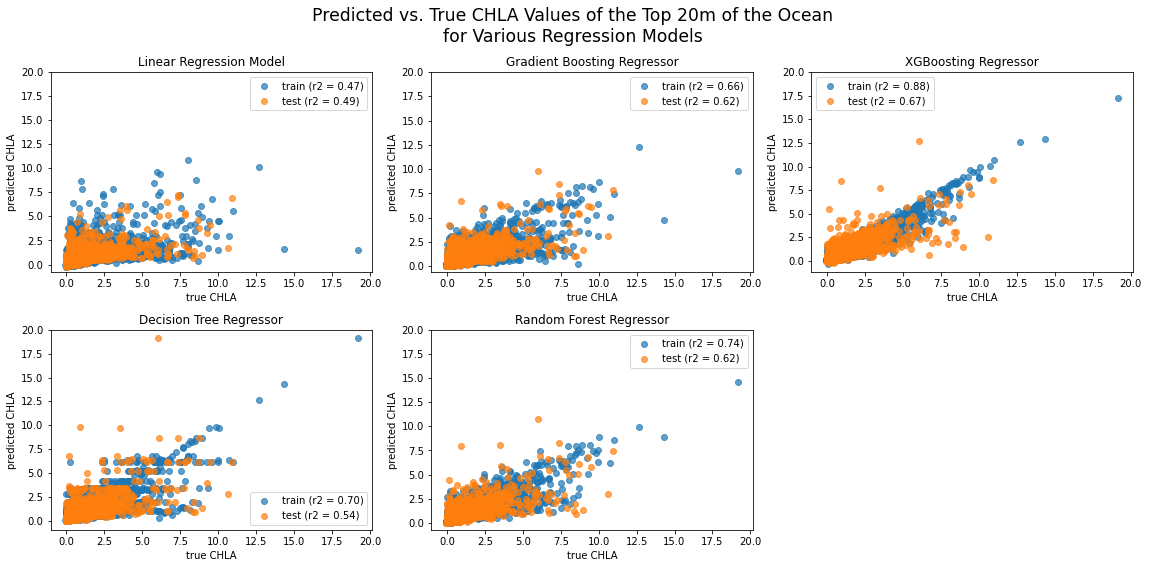

In [12]:
plt.figure(figsize=(16,8))
plt.suptitle('Predicted vs. True CHLA Values of the Top 20m of the Ocean\nfor Various Regression Models', fontsize='xx-large')
subplot = 1

lr = LinearRegression()
scores = get_model_scores(lr, X_train, y_train)
train_preds, test_preds = fit_predict(lr, X_train, X_test, y_test)
plot(y_train, train_preds, y_test, test_preds, subplot=subplot, title='Linear Regression Model')
subplot += 1
results_df.loc[results_df.shape[0]] = ['linear_regression'] + scores
print()

# fit a gradient booting regression model
gbr = GradientBoostingRegressor()
scores = get_model_scores(gbr, X_train, y_train)
train_preds, test_preds = fit_predict(gbr, X_train, X_test, y_test)
plot(y_train, train_preds, y_test, test_preds, subplot=subplot, title='Gradient Boosting Regressor')
subplot += 1
results_df.loc[results_df.shape[0]] = ['gradient_booting_regressor'] + scores
print()

# fit a gradient booting regression model
xgbr = XGBRegressor()
scores = get_model_scores(xgbr, X_train, y_train)
train_preds, test_preds = fit_predict(xgbr, X_train, X_test, y_test)
plot(y_train, train_preds, y_test, test_preds, subplot=subplot, title='XGBoosting Regressor')
subplot += 1
results_df.loc[results_df.shape[0]] = ['xgbregressor'] + scores
print()

# fit a gradient booting regression model
dtr = DecisionTreeRegressor(max_depth=8)
scores = get_model_scores(dtr, X_train, y_train)
train_preds, test_preds = fit_predict(dtr, X_train, X_test, y_test)
plot(y_train, train_preds, y_test, test_preds, subplot=subplot, title='Decision Tree Regressor')
subplot += 1
results_df.loc[results_df.shape[0]] = ['decision_tree_regressor'] + scores
print()

# fit a random forest regression model
rfr = RandomForestRegressor(n_estimators=50, max_depth=8)
scores = get_model_scores(rfr, X_train, y_train)
train_preds, test_preds = fit_predict(rfr, X_train, X_test, y_test)
plot(y_train, train_preds, y_test, test_preds, subplot=subplot, title='Random Forest Regressor')
subplot += 1
results_df.loc[results_df.shape[0]] = ['random_forest_regressor'] + scores
print()

plt.tight_layout()
plt.show()


In [13]:
# note: these values are a result of cross validation;
# test scores over the entire test set are not included in the table,
# but can be found in the plots above
results_df


,model,train_mse,train_r2,test_mse,test_r2
0,linear_regression,0.262624,0.472078,0.263944,0.468953
1,gradient_booting_regressor,0.166803,0.664741,0.201874,0.594593
2,xgbregressor,0.051134,0.897217,0.180577,0.637654
3,decision_tree_regressor,0.140161,0.718333,0.235156,0.526877
4,random_forest_regressor,0.127083,0.744564,0.193331,0.611176


In [14]:
print('Best baseline model found for this data (measured by test R2):')
results_df[results_df['test_r2'] == max(results_df['test_r2'])]
# note: the final test R2 on all test data was 0.67


Best baseline model found for this data (measured by test R2):


,model,train_mse,train_r2,test_mse,test_r2
2,xgbregressor,0.051134,0.897217,0.180577,0.637654


## Additional considerations

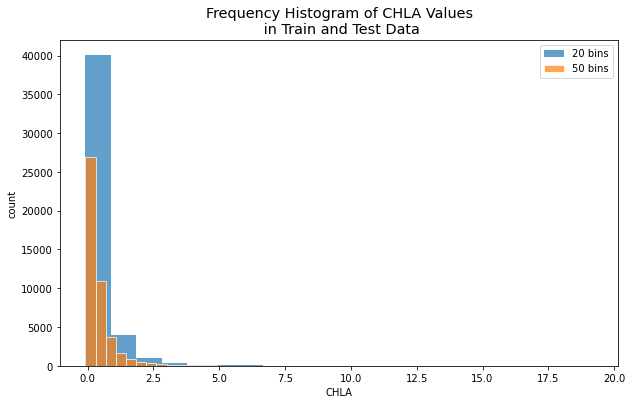

In [15]:
# note: this shows that train-test-split should be stratified if binning target to be categorical
plt.figure(figsize=(10,6))
plt.hist(list(y_train) + list(y_test), bins=20, alpha=0.7, label='20 bins')
plt.hist(list(y_train) + list(y_test), bins=50, edgecolor='white', alpha=0.7, label='50 bins')
plt.title('Frequency Histogram of CHLA Values\n in Train and Test Data', fontsize='x-large')
plt.xlabel('CHLA')
plt.ylabel('count')
plt.legend()
plt.show()


In [16]:
# note: results worsen as smaller depths from the surface are taken (ex. depth_thresh = 5)
# it is worth looking into how to best define "surface", depth bins, etc. to optimize predictions
